# Notebook 3-1: Static Spectra

In this notebook, we will cover:
1. Loading data.
2. Calculating static power spectra.
3. Static power analysis.

## 1. Loading data

First, we load the source reconstructed (parcel) data.

In [1]:
from glob import glob
from osl_dynamics.data import Data

files = sorted(glob("wakeman-henson/*/*_sflip_lcmv-parc-raw.fif"))
data = Data(files, picks="misc", reject_by_annotation="omit")
print(data)

Loading files:   0%|          | 0/5 [00:00<?, ?it/s]

Data
 id: 4577468800
 n_sessions: 5
 n_samples: 599252
 n_channels: 38


We have 5 session that were generated with the 'Giles' (`fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz`) parcellation.

## 2. Calculating static power spectra

Here, we calculate 'static' (i.e. time averaged) spectral properties. This can be thought of as a single state HMM.

Using the data we just loaded, we want to calculate the power spectra for each channel (ROI) for each subject. We will use the [osl-dynamics.analysis.static.welch_spectra](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/analysis/static/index.html#osl_dynamics.analysis.static.welch_spectra) function to do this. This function implements Welch's methods for calculating power spectra.

To use this function we need to specify at least two arguments:
- `sampling_frequency`. This is to ensure we get the correct frequency axis for the power spectra.
- `window_length`. This is the number of samples in the sliding window. The longer the window the smaller the frequency resolution of the power spectrum. Twice the sampling frequency is generally a good choice for this, which gives a frequency resolution of 0.5 Hz.
We can also specify an optional argument:

We can also specify an optional argument:
- `standardize`. This will z-transform the data (for each subejct separately) before calculate the power spectra. This can be helpful if you want to examine power the fraction of power in a frequency band relative to the total power (across all frequencies) of the subject.

In [2]:
from osl_dynamics.analysis import static

ts = data.time_series()
f, psd = static.welch_spectra(
    data=ts,
    sampling_frequency=250,
    window_length=500,
    standardize=True,
)

Calculating spectra:   0%|          | 0/5 [00:00<?, ?it/s]

We have two numpy arrays: `f`, which is the frequency axis of the power spectra in Hz, and `p`, which contains the power spectra.

Calculating power spectra can be time consuming. We will want to use the power spectra many times to make different plots. We don't want to have to calculate them repeatedly, so often it is convinent to save the `f` and `p` numpy arrays so we can load them later (instead of calculating them again). Let's save the spectra.

In [3]:
import os
import numpy as np

os.makedirs("spectra", exist_ok=True)
np.save("spectra/f.npy", f)
np.save("spectra/psd.npy", psd)

## 3. Static power analysis

Now that we've calculated static power spectra, let's do some static power analysis. To begin we plot the static PSD for the first session.

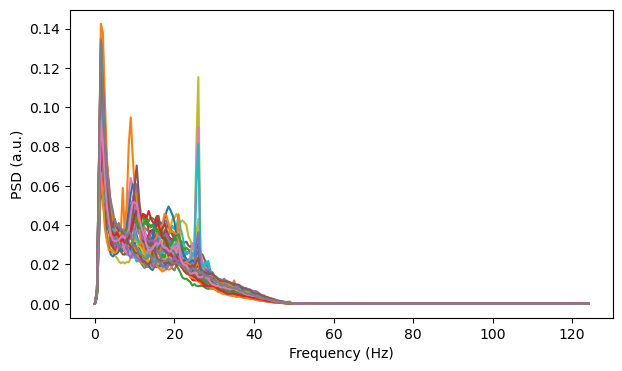

In [4]:
from osl_dynamics.utils import plotting

fig, ax = plotting.plot_line(
    [f] * psd.shape[1],
    psd[0],
    x_label="Frequency (Hz)",
    y_label="PSD (a.u.)",
)

Each line in this plot is a ROI. Rather than plotting the PSD for each parcel, let's plot the average across parcels for each session.

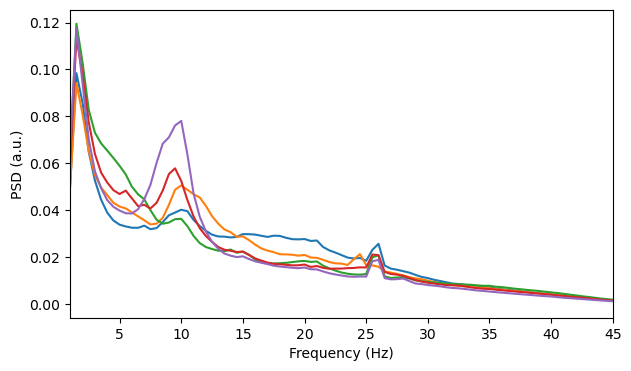

In [5]:
# Average over channels
psd_mean = np.mean(psd, axis=1)

# Plot
fig, ax = plotting.plot_line(
    [f] * len(psd_mean),
    psd_mean,
    x_label="Frequency (Hz)",
    y_label="PSD (a.u.)",
    x_range=[1, 45],
)

Let's say we are interested in alpha (10 Hz) power. We can calculate alpha power by integrating a power spectrum over a frequency range near 10 Hz. Typically, 7-13 Hz power is referred to as the 'alpha band'. Other common frequency bands are:

- Delta: 1-4 Hz.
- Theta: 4-7 Hz.
- Beta: 13-30 Hz.
- Gamma: 30+ Hz.

osl-dynamics has a [analysis.power.variance_from_spectra](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/analysis/power/index.html#osl_dynamics.analysis.power.variance_from_spectra) function to calculate power from a spectrum. Let's use this function to calculate power for the alpha band.

In [6]:
from osl_dynamics.analysis import power

# Calculate power in the alpha band (8-12 Hz) from the spectra
p = power.variance_from_spectra(f, psd, frequency_range=[7, 13])
print(p.shape)

(5, 38)


We can use [power.save](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/analysis/power/index.html#osl_dynamics.analysis.power.save) to visualise the power maps. Let's plot the group average.

Saving images:   0%|          | 0/1 [00:00<?, ?it/s]

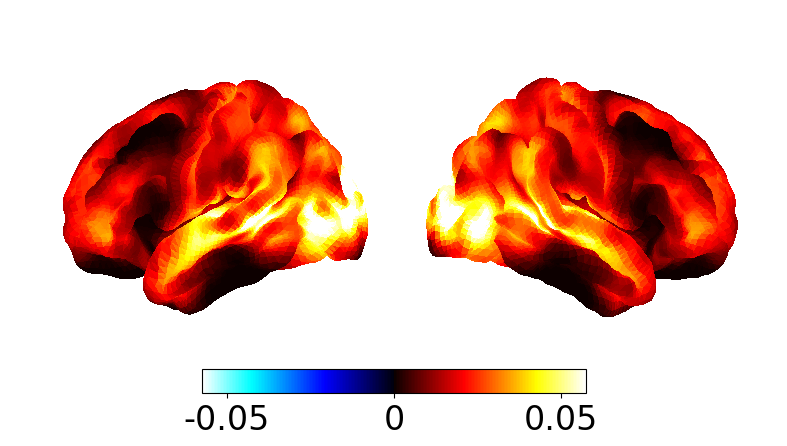

In [7]:
group_p = np.mean(p, axis=0)

fig, ax = power.save(
    group_p,
    mask_file="MNI152_T1_8mm_brain.nii.gz",
    parcellation_file="fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz",
)

## Exercise

How can you compare the static power maps for two different groups.

Solution: see the [group difference tutorial](https://osl-dynamics.readthedocs.io/en/latest/tutorials_build/group_contrast.html).